In [2]:
## Análise da mortalidade infantil entre os anos de 2010 e 2016 no Brasil
## Entre crianças menores de 4 anos

# Importando os pacotes necessários

import basedosdados as bd
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify
from geobr import read_state
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Carregando as bases

## informações sobre mortalidade, selecionando os anos e a faixa etária de interesse
df_sim = bd.read_sql(
    """
    SELECT ano,id_municipio,sigla_uf, SUM(numero_obitos) AS total_obitos, 
    FROM `basedosdados.br_ms_sim.municipio_causa_idade` AS sim
    WHERE ano IN('2010','2011','2012','2013','2014','2015','2016') AND idade <= 4
    GROUP BY ano, id_municipio,sigla_uf    
    """,
    billing_project_id="project0bd")

## informações sobre estimativas populacionais, selecionando os anos e a faixa etária de interesse
df_pop = bd.read_sql(
    """
    SELECT ano, SUM(populacao) AS pop_idade, id_municipio
    FROM `basedosdados.br_ms_populacao.municipio` 
    WHERE grupo_idade = "0-4 anos" AND ano > 2009 AND ano < 2017
    GROUP BY ano, id_municipio
    """,
    billing_project_id="project0bd")

## Geobr
states_10 = read_state(year=2010)
states_16 = read_state(year=2016)

Downloading: 100%|██████████████████████████████████████████████████████████| 38975/38975 [00:02<00:00, 18712.84rows/s]


In [3]:
#print(df_sim.dtypes)
#print(df_pop.dtypes)

## Tratamento e cruzamento dos dados
df_sim['ano']=df_sim['ano'].astype(int)
df_simpop = pd.merge(df_sim, df_pop,  on = ["ano", "id_municipio"])

## Aqui estamos criando indicador de referência, o número de óbitos a cada 1000 habitantes   
df_simpop['taxa_obitos'] = (df_simpop['total_obitos']/df_simpop['pop_idade'])*1000

# Agrupando por estados
df_estados = df_simpop.groupby(['ano','sigla_uf'],as_index=False)[["taxa_obitos"]].mean()
df_estados['taxa_obitos']  = df_estados['taxa_obitos'].astype(int)
df_estados = df_estados.rename(columns={'sigla_uf': 'abbrev_state'})

# Criando bases com as informações do primeiro e do último ano da janela temporal, para comparação
## cruzando essas bases com os dados georreferenciados do pacote geobr  
estados10 = df_estados.loc[df_estados['ano'] == 2010]
estados16 = df_estados.loc[df_estados['ano'] == 2016]
df_estados10 = pd.merge(estados10, states_10,  on = ["abbrev_state"])
df_estados16 = pd.merge(estados16, states_16,  on = ["abbrev_state"])

# Agrupando nacionalmente
df_brasil = df_simpop.groupby(['ano'],as_index=False)[["taxa_obitos"]].mean()

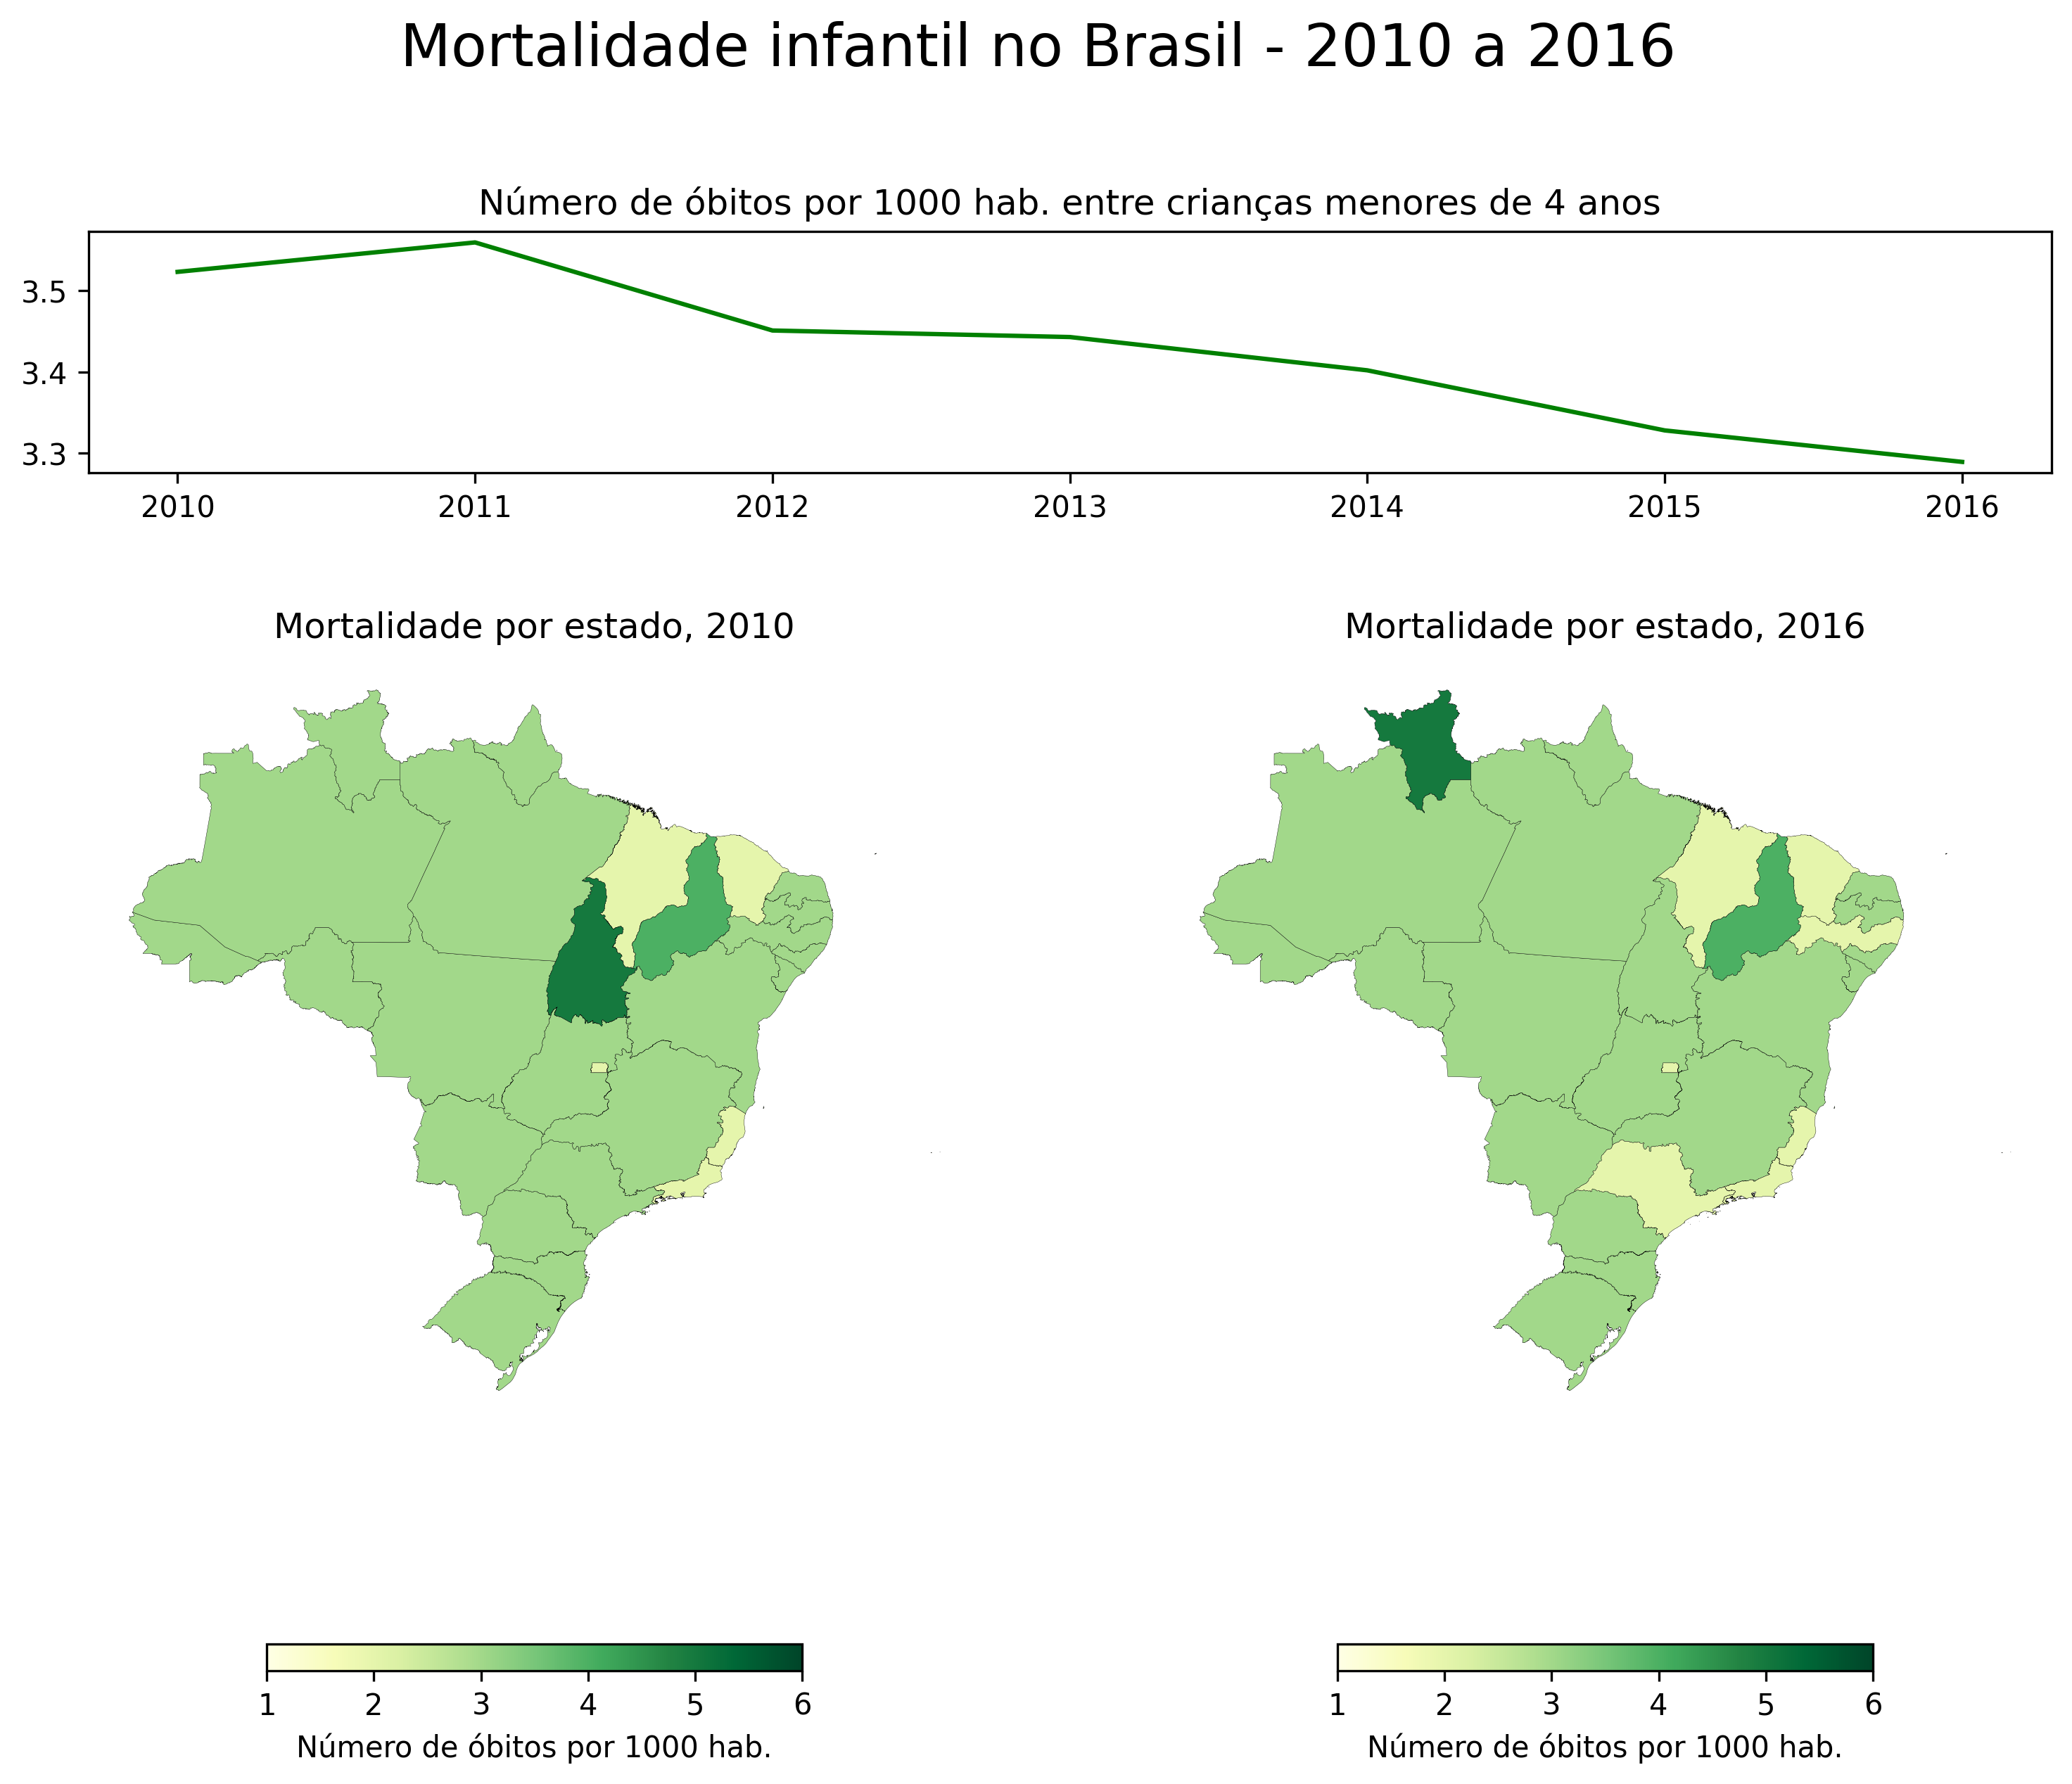

In [4]:
# Visualização dos dados

# Transformar bases para construir mapa
df_estados10 = gpd.GeoDataFrame(df_estados10)
df_estados16 = gpd.GeoDataFrame(df_estados16)

# Configurando a área da visualização
fig = plt.figure(figsize=(12, 10),dpi = 300)
gs = GridSpec(nrows=2, ncols=2, width_ratios=[5, 5], height_ratios=[1, 5])

# Primeiro eixo - Índice de mortalidade por ano, a nível nacional
ax0 = fig.add_subplot(gs[0, :]) 
x = df_brasil["ano"]
y = df_brasil["taxa_obitos"]
plt.plot(x, y, c = 'green') 
plt.suptitle("Mortalidade infantil no Brasil - 2010 a 2016",fontsize = 20)
plt.title("Número de óbitos por 1000 hab. entre crianças menores de 4 anos")

# Segundo eixo - Mapa mostrando o índice de mortalidade por estado, em 2010
ax1 = fig.add_subplot(gs[1, 0]) 
divider = make_axes_locatable(ax1)
df_estados10.plot(
    column="taxa_obitos",
    cmap="YlGn",
    legend = True,
    legend_kwds={
        "label": "Número de óbitos por 1000 hab.",
        "orientation": "horizontal",
        "shrink": 0.6},
    vmin = 1, vmax = 6,
    edgecolor='black',
        linewidth = 0.1,
    ax=ax1
)
ax1.set_axis_off()
ax1.set_title("Mortalidade por estado, 2010")

# Terceiro eixo - Mapa mostrando o índice de mortalidade por estado, em 2019
ax2 = fig.add_subplot(gs[1, 1]) #tx10
divider = make_axes_locatable(ax2)
df_estados16.plot(
    column="taxa_obitos",
    cmap="YlGn",
    legend = True,
    legend_kwds={
        "label": "Número de óbitos por 1000 hab.",
        "orientation": "horizontal",
        "shrink": 0.6},
    vmin = 1, vmax = 6,
    edgecolor='black',
        linewidth = 0.1,
    ax=ax2
) 
ax2.set_axis_off()
ax2.set_title("Mortalidade por estado, 2016")

# Salvando e plotando a figura
plt.savefig("mortalidade_infantil_visualizacao.jpg")
plt.show()